In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import pickle
import adniEnsemble as adens

In [2]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [3]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [4]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [5]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [6]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


## MRI

In [7]:
## prepare data with appropriate features and randomization
shuffled_df = mridf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age','APOE'], mri_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e0, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
sensitivity_test, specificity_test = adens.SensiSpeci(testing_Y, mlmodel.predict(testing_X))
# test model - training data
sensitivity_train, specificity_train = adens.SensiSpeci(training_Y, mlmodel.predict(training_X))

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 82.97, Specificity: 92.53
Train: Sensitivity = 84.94, Specificity: 93.88


In [9]:
myout = pickle.load(open('../Dataset/ProcessedFiles/logistic_regression_amyloid_cv.pckl','rb'))

print([gridout['test_score']['accuracy'] for gridout in myout])

myout = pickle.load(open('../Dataset/ProcessedFiles/logistic_regression_amyloid_factors_cv.pckl','rb'))

print([gridout['test_score']['accuracy'] for gridout in myout])

[83.85650224215246, 84.75336322869956, 82.95964125560538, 83.85650224215246, 82.95964125560538, 83.85650224215246, 85.65022421524664, 87.4439461883408, 84.30493273542601, 81.16591928251121]
[86.54708520179372, 85.65022421524664, 85.65022421524664, 84.75336322869956, 84.30493273542601, 85.65022421524664, 87.4439461883408, 88.78923766816143, 83.85650224215246, 82.95964125560538]


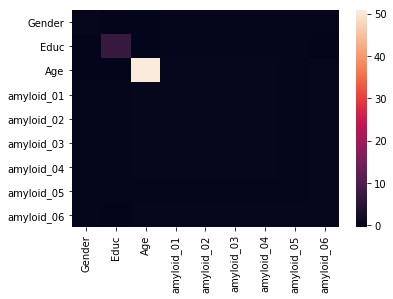

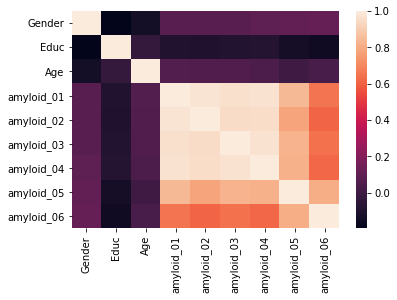

In [9]:
features = [item for sublist in [['Gender','Educ','Age'],amyloid_vars] for item in sublist]
sns.heatmap(amyloiddf[features].cov())
plt.show()
sns.heatmap(((amyloiddf[features]-amyloiddf[features].mean())/(amyloiddf[features].std())).cov())
plt.show()

In [10]:
amyloiddfzs = amyloiddf.copy()
amyloiddfzs[features] = (amyloiddfzs[features]-amyloiddfzs[features].mean())/(amyloiddfzs[features].std())


In [19]:
svc_param_grid = {'C':np.logspace(-2,2,5), 'kernel':['linear','poly'], 'degree':[2], 'gamma':[10]}
amyloiddfzs['DX_bin'] = np.where(amyloiddfzs["DX"]=="CN", 0, 1)

grid_out = adens.ttSplitWithGridSearch('svm', svc_param_grid, 4, 
                                              amyloiddfzs, amyloid_vars, 'DX_bin', 0.8, 0) 

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
amyloiddf['DX_bin'] = np.where(amyloiddf["DX"]=="CN", 0, 1)
grid_out = adens.ttSplitWithGridSearch('svm', svc_param_grid, 4, 
                                              amyloiddf, features, 'DX_bin', 0.8, 0) 

In [26]:
np.logspace(-2,2,5)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [30]:
print(np.mean([gridout['test_score']['accuracy'] for gridout in pickle.load(open('../Dataset/ProcessedFiles/amyloid_logistic_regression_cv.pckl','rb'))]))
print(np.mean([gridout['test_score']['accuracy'] for gridout in pickle.load(open('../Dataset/Archive/logistic_regression_amyloid_cv.pckl','rb'))]))

83.76681614349776
84.08071748878923
